# The netCDF file format

* popular scientific file format for ocean and atmospere gridded datasets
* netCDF is a collection of formats for storing arrays

    * netCDF classic
        * more widespread
        * 2 GB file limit (if you don't use the unlimited dimension)
        * often preffered for distributing products

    * netCDF 64 bit offset
        * supports larger files

    * NetCDF4
        * based on HDF5
        * compression
        * multiple unlimited variables
        * new types inc. user defined
        * herarchical groups
        
        

* Developed by Unidata-UCAR with the aim of storing climate model data (3D+time)
* Auxilary information about each variable can be added
* Readable text equivalent called CDL (use ncdump/ncgen)
* Can be used with Climate and Forecast (CF) data convention
http://cfconventions.org/

## Data model:

* Dimensions:describe the axes of the data arrays.
* Variables: N-dimensional arrays of data.
* Attributes: annotate variables or files with small notes or supplementary metadata.

Example for an ocean model dataset:

* Dimensions
    * lat
    * lon
    * depth
    * time
* Variable
    * Temperature
    * Salinity
* Global Attibutes
    * Geographic grid type
    * History



* Variable attributes (Temperature)
    * Long_name: "sea water temperature" 
    * Missing_value: 1.09009E36
    * Units: deg. C
    * range: -2:50

## Example dataset structure
http://xarray.pydata.org/en/stable/data-structures.html

<br>
<img src="../../figures/dataset-diagram.png">


## Python packages
* The main Python interface to the netCDF C library is [netCDF4](http://unidata.github.io/netcdf4-python/) package
* In this tutorial, however, we will use a more high-level package that has a **pandas-like API**: [xarray](http://xarray.pydata.org/en/stable/index.html).
* Another good package is [iris](http://scitools.org.uk/iris/).

# Working with netCDF files using xarray

* Alternative to plain netCDF4 access from python. 

* Brings the power of pandas to environmental sciences, by providing N-dimensional variants of the core pandas data structures:

* worth using for multidimensional data even when not using 

| Pandas | xarray  |
|---|---|
| Series  | DataArray  |
| DataFrame  | Dataset  |


DataArray uses names of dimensions making it easier to track than by using axis numbers. It is possible to write:

`da.sel(time='2000-01-01')` or `da.mean(dim='time')`
intead of ``df.mean(0)``

HTML documentation: http://xarray.pydata.org/

Thus, xarray operations allow you to use names, not numbers!
Compare:
```python
# xarray style
>>> ds.sel(time='2018-01-12').max(dim='ensemble')

# numpy style
>>> array[[0, 1, 2, 3], :, :].max(axis=2)
```

(Taken from Stephan Hoyer's [ECMWF talk](https://docs.google.com/presentation/d/16CMY3g_OYr6fQplUZIDqVtG-SKZqsG8Ckwoj2oOqepU/edit#slide=id.g2b68f9254d_1_27))

### The main advantages of using xarray versus plain netCDF4 are:

* intelligent selection along labelled dimensions (and also indexes)
* groupby operations
* data alignment
* IO (netcdf)
* conversion from and to Pandas.DataFrames

In [1]:
# Import everything that we are going to need
import pandas as pd
import xarray as xr
import numpy as np

## Import a local dataset

In [2]:
GETM = xr.open_dataset('../../data/cefas_GETM_nwes.nc4')
GETM

<xarray.Dataset>
Dimensions:     (latc: 360, level: 5, lonc: 396, time: 6)
Coordinates:
  * latc        (latc) float64 45.4 45.45 45.5 45.55 ... 63.2 63.25 63.3 63.35
  * level       (level) float64 1.0 6.0 11.0 16.0 21.0
  * lonc        (lonc) float64 -17.5 -17.42 -17.34 -17.26 ... 13.94 14.02 14.1
  * time        (time) datetime64[ns] 1996-02-01T01:00:00 ... 1996-02-06T01:0...
Data variables:
    bathymetry  (latc, lonc) float64 ...
    h           (time, level, latc, lonc) float32 ...
    temp        (time, level, latc, lonc) float32 ...
Attributes:
    title:                     North West European Shelf 3nm
    history:                   Sun Nov 20 00:54:48 2016: ncks -v time,latc,lo...
    NCO:                       4.4.8
    nco_openmp_thread_number:  1

We can see that this file holds bathymetryic, height and tempearture data for a gridded area of the North West European Shelf

We can print these dimensions to see the extent of the netCDF

In [3]:
GETM.latc
#GETM.lonc
#GETM.time
#GETM.level

<xarray.DataArray 'latc' (latc: 360)>
array([45.400002, 45.450002, 45.500002, ..., 63.249999, 63.299999, 63.349999])
Coordinates:
  * latc     (latc) float64 45.4 45.45 45.5 45.55 45.6 ... 63.2 63.25 63.3 63.35
Attributes:
    units:    degrees_north

In [4]:
print(type(GETM.coords['latc']))
GETM.coords['latc'].shape

<class 'xarray.core.dataarray.DataArray'>


(360,)

In [5]:
# List name of dataset attributes
GETM.attrs.keys()

dict_keys(['title', 'history', 'NCO', 'nco_openmp_thread_number'])

In [6]:
# List variable names
GETM.data_vars.keys()

KeysView(Data variables:
    bathymetry  (latc, lonc) float64 ...
    h           (time, level, latc, lonc) float32 ...
    temp        (time, level, latc, lonc) float32 ...)

This tells  us that bathymetry is 2D, varying only wiht lat and lon. Height and temp are 4D, varying with time and model level as well

Extract variable from dataset

In [7]:
temp = GETM['temp']
print(type( temp ))
temp.shape

<class 'xarray.core.dataarray.DataArray'>


(6, 5, 360, 396)

Access variable attributes

In [8]:
# print variable attributes

for at, val in temp.attrs.items():
    print(f'{at:<15}: {val}')

units          : degC
long_name      : temperature
valid_range    : [-2. 40.]


## Accessing data values

In [9]:
temp[0, 0, 90, 100]

<xarray.DataArray 'temp' ()>
array(11.532867)
Coordinates:
    latc     float64 49.9
    level    float64 1.0
    lonc     float64 -9.5
    time     datetime64[ns] 1996-02-01T01:00:00
Attributes:
    units:        degC
    long_name:    temperature
    valid_range:  [-2. 40.]

In [10]:
temp.values[0, 0, 90, 100]

11.532867

## Indexing and selecting data

From http://xarray.pydata.org/
<br>
<img src="../figures/xarray_indexing_table.png">

In [11]:
#positional by integer
print( temp[0, 2, :, :].shape )

# positional by label
print( temp.loc['1996-02-02T01:00:00', :, :, :].shape )

# by name and integer
print( temp.isel(level=1, latc=90, lonc=100).shape )

# by name and label
print( temp.sel(time='1996-02-02T01:00:00').shape )
#temp.loc

(360, 396)
(5, 360, 396)
(6,)
(5, 360, 396)


### Define selection using nearest value

In [12]:
#GETM.sel(level=1)['temp']
GETM['temp'].sel(level=2, lonc=-5.0, latc=50.0, method='nearest')

<xarray.DataArray 'temp' (time: 6)>
array([9.513756, 9.479022, 9.506635, 9.484008, 9.596508, 9.748465],
      dtype=float32)
Coordinates:
    latc     float64 50.0
    level    float64 1.0
    lonc     float64 -5.02
  * time     (time) datetime64[ns] 1996-02-01T01:00:00 ... 1996-02-06T01:00:00
Attributes:
    units:        degC
    long_name:    temperature
    valid_range:  [-2. 40.]

In [13]:
# Use tolerance for label selection (lat=-50 should not yield data)
tol = 0.5

try:
    GETM['temp'].sel(level=1, lonc=-5.0, latc=-50.0, method='nearest', tolerance=tol)
except KeyError:
    print(f'ERROR: outside tolerance of {tol}')

ERROR: outside tolerance of 0.5


## Plotting

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

Define a general mapping function using cartopy

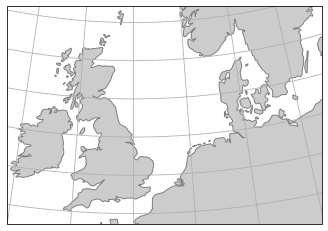

In [15]:
#def make_map(ds, var='', title=None, units=None):
def make_map():
    # create figure and axes instances
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=ccrs.Stereographic(central_latitude=60))
    #ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_extent([-10, 15, 49, 60], crs=ccrs.PlateCarree())
    
    gl = ax.gridlines(draw_labels=False)
    
    feature = cartopy.feature.NaturalEarthFeature(name='coastline',
                                                  category='physical',
                                                  scale='50m',
                                                  edgecolor='0.5',
                                                  facecolor='0.8')
    ax.add_feature(feature)
    return fig, ax

make_map();

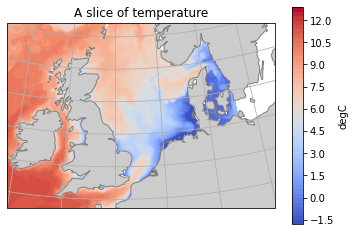

In [16]:
latc = GETM.coords['latc']
lonc = GETM.coords['lonc']

var = GETM.temp.sel(time='1996-02-02T01:00:00', level=21)

# create arrays of coordinates for contourf
# lon2d, lat2d = np.meshgrid(lonc, latc)

fig, ax = make_map()
# draw filled contours.
h = ax.contourf(lonc, latc, var, 50, cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree())

# add colorbar.
cbar = fig.colorbar(h)
cbar.set_label(var.units)

# add title
ax.set_title(f'A slice of {var.long_name}');

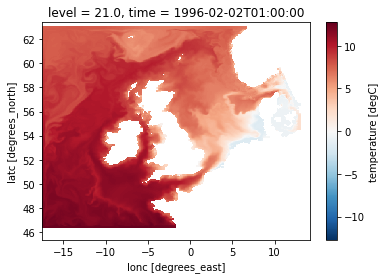

In [17]:
# But often, this will do
#GETM.temp.isel(time=0, level=0).plot();
GETM.temp.sel(time='1996-02-02T01:00:00', level=21).plot();

## Arithmetic operations

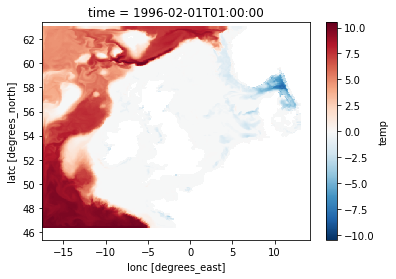

In [18]:
top = GETM['temp'].isel(time=0, level=4)
bottom = GETM['temp'].isel(time=0, level=0)

diff = top - bottom

diff.plot()

### Calculate average along a dimension

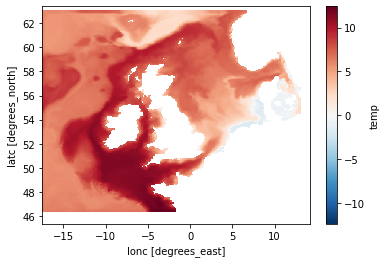

In [19]:
# average over time
time_ave = GETM['temp'].mean('time')

#average over time and level (vertical)
time_and_level_ave = GETM['temp'].mean(['time','level'])

time_and_level_ave.plot()

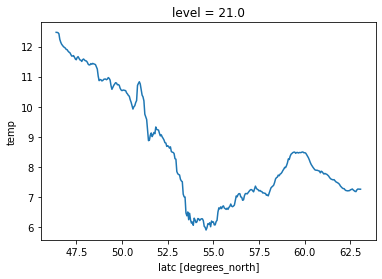

In [20]:
#zonal average (vertical)
timelon_ave = GETM['temp'].mean(['time','lonc']).isel(level=4)

timelon_ave.plot()

Using **xarray** we have the data access power of **netCDF4** with all the intelligent selection, arithmetic, statistical methods and plotting of **pandas**

## A dataset can easily be saved to a netCDF file

In [22]:
ds = GETM[['temp']].mean('time','level')
ds.to_netcdf('../../data/temp_avg_level_time.nc')

## Exercise

* Extract the bathymetry
* Extract the time averaged seabed temperature (level=0)
* Produce a scatter plot of depth vs. seabed temperature


In [23]:
GETM.data_vars.keys()

KeysView(Data variables:
    bathymetry  (latc, lonc) float64 ...
    h           (time, level, latc, lonc) float32 ...
    temp        (time, level, latc, lonc) float32 nan nan nan ... nan nan nan)

In [24]:
# solution
da_bathy = GETM['bathymetry']

In [25]:
# solution
temp_avg_lvl0 = GETM['temp'].isel(level=0).mean(dim='time')

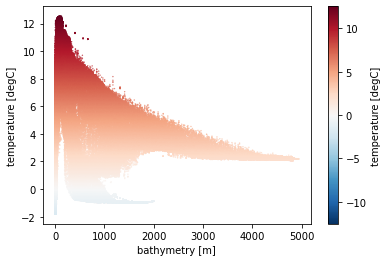

In [39]:
# solution
seabed = GETM.isel(level=0)
xr.plot.scatter(seabed, 'bathymetry', 'temp', hue='temp', s=.5, marker='.')

In [ ]:
# Scroll down for a solution

In [ ]:
# First get the bathy and temp data
bathy=GETM['bathymetry']
bedtemp=GETM['temp'].mean('time').isel(level=0)

In [ ]:
bathy.plot();

In [ ]:
bedtemp.plot()

In [ ]:
# Make a simple scatter plot
fig, ax = plt.subplots()
ax.scatter(bathy,bedtemp,marker='.',s=1.0)
ax.set_xlabel('Bathymetry (m)')
ax.set_ylabel('Bottom temperature (deg. C)');

## Import remote dataset

xarray supports OpenDAP. This means that a dataset can be accessed remotely and subsetted as needed. Only the selected parts are downloaded.

# Excercise:
Import data from a netCDF or csv file and start exploring it. Some ideas:
- Use pandas to get quick statistics
- Do some data cleaning and calculations wtih numpy
- Plot it up with matplotlib, pandas, seaborn or cartopy as you prefer

I encourage you to use your own data if you have some. If not, we have some sample datasets you can explore:

### Earthquake data (csv file)
US Geological Survey (USGS) provides various [earthquakes data](https://earthquake.usgs.gov/data/data.php#eq) on a global scale. Its Earthquake Catalog contains earthquake source parameters (e.g. hypocenters, magnitudes, phase picks and amplitudes) and other products (e.g. moment tensor solutions, macroseismic information, tectonic summaries, maps) produced by contributing seismic networks.

If you follow this [link](http://earthquake.usgs.gov/earthquakes/search/), you can search throught the catalog and filter data by the magnitude, time and geographic region. In the `data/` folder, we provide an [example dataset](../data/earthquakes_2015_2016_gt45.csv) of earthquakes with magnitude >4.5 that occurred around the world over the period of a year.

To get you started, the following cell loads the data into a pandas DataFrame

In [2]:
import pandas as pd
df = pd.read_csv('../../data/earthquakes_2015_2016_gt45.csv', parse_dates = ['time',], index_col='time')
df.head()

,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
time,,,,,,,,,,,,,,,,,,,,,
2016-11-22 16:03:30.770000+00:00,-24.8982,179.7713,517.23,5.0,mb,NaN,52.0,4.790,1.14,us,...,2016-11-22T16:27:59.040Z,South of the Fiji Islands,earthquake,11.0,6.9,0.035,257.0,reviewed,us,us
2016-11-22 15:15:19.680000+00:00,-44.1111,38.3580,10.00,4.7,mb,NaN,52.0,17.568,0.87,us,...,2016-11-22T17:02:14.040Z,Prince Edward Islands region,earthquake,12.4,1.9,0.113,24.0,reviewed,us,us
2016-11-22 14:10:40.650000+00:00,54.1202,-160.0522,16.19,4.9,mb,NaN,159.0,0.761,0.74,us,...,2016-11-22T16:48:48.040Z,"80km SSW of Chernabura Island, Alaska",earthquake,6.1,4.9,0.078,51.0,reviewed,us,us
2016-11-22 14:04:07.620000+00:00,-41.7822,174.1635,13.77,4.5,mb,NaN,105.0,0.050,0.73,us,...,2016-11-22T14:40:26.040Z,"34km SSE of Blenheim, New Zealand",earthquake,2.1,2.2,0.180,9.0,reviewed,us,us
2016-11-22 14:03:58.570000+00:00,37.2297,141.3797,13.16,5.2,mb,NaN,88.0,0.791,0.55,us,...,2016-11-22T16:25:04.075Z,"43km SE of Namie, Japan",earthquake,4.9,3.4,0.041,199.0,reviewed,us,us


If you want to build your project on these data, some possible ideas are:
* `pandas` package will be most useful to read in the data, as well as analyse them
* Use `cartopy` to plot the data using longitude and latitude columns
* Explore `pandas`' `groupby()` method, which you can use to aggregate data by time or other parameter
* Create a histogram of earthquakes magnitude

### Arctic Sea Ice (netCDF files)
* In this project you are offered to use NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration.
* In the `../data/` directory, there are 2 netCDF files `seaice_conc_monthly*` that correspond to September 1991  and September 2012 .
* If you want to download data for other months, visit the [NSIDC's data portal](https://nsidc.org/data/search/#keywords=sea+ice/sortKeys=score,,desc/facetFilters=%257B%257D/pageNumber=1/itemsPerPage=25).

For this project, I recommend that you:
* use `xarray` for opening and reading the netCDF files
* use `cartopy` for creating a plot with a correct map projection
* use appropriate colormaps for the sea ice concentration and difference between the two years

Some code to get you started:

In [36]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import xarray as xr

In [6]:
ds1 = xr.open_dataset('../../data/seaice_conc_monthly_nh_f08_199109_v02r00.nc')
ds2 = xr.open_dataset('../../data/seaice_conc_monthly_nh_f17_201209_v02r00.nc')

/Users/nelereyniers/anaconda3/envs/ppd_python/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'melt_onset_day_seaice_conc_monthly_cdr' has multiple fill values {-1, 65535}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [85]:
diff_1991_2012 = ds1['goddard_nt_seaice_conc_monthly'].isel(time=0).load() - ds2['goddard_nt_seaice_conc_monthly'].isel(time=0).load()

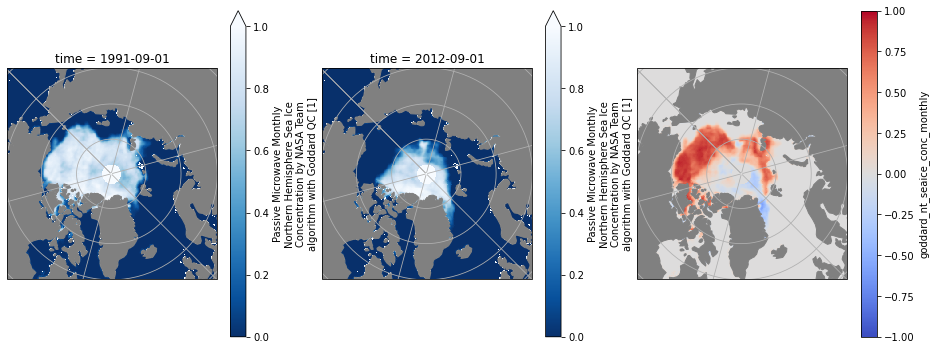

In [89]:
# example solution
fig, axes = plt.subplots(1, 3, figsize=(16,6),
                         subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-45,
                                                                          true_scale_latitude=70)))
ds1['goddard_nt_seaice_conc_monthly'].plot(ax=axes[0], 
                                           transform=ccrs.NorthPolarStereo(central_longitude=-45,
                                                                           true_scale_latitude=70),
                                           vmax=1, vmin=0, cmap='Blues_r')
ds2['goddard_nt_seaice_conc_monthly'].plot(ax=axes[1], 
                                           transform=ccrs.NorthPolarStereo(central_longitude=-45,
                                                                           true_scale_latitude=70),
                                           vmax=1, vmin=0, cmap='Blues_r')
# plot the difference:
diff_1991_2012.plot(ax=axes[2], transform=ccrs.NorthPolarStereo(central_longitude=-45,
                                                                true_scale_latitude=70),
                                                               vmax=1, vmin=-1, cmap='coolwarm')

for ax in axes:
    ax.set_extent([-179.99, 180, 60, 90], crs=ccrs.PlateCarree())
    # ax.coastlines(resolution='110m', linewidth=2)
    ax.gridlines()
    ax.add_feature(cartopy.feature.NaturalEarthFeature(name='land', category='physical',
                                                       scale='110m',
                                                       edgecolor='grey', facecolor='grey'))